# Neural Style Transfer 

# Import Libraries and Tools

In [3]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
import matplotlib.pyplot as plt
import keras
%matplotlib inline

# Importing the Model

In [4]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.python.keras.applications.vgg19 import VGG19

In [5]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Image Processing and Display

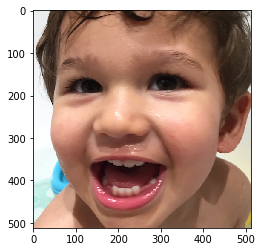

In [6]:
content_image=Image.open('content.png')
content_image=content_image.resize((512,512))
plt.imshow(content_image)
plt.show()

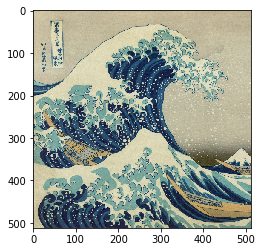

In [7]:
style_image= Image.open('style.png')
style_image=style_image.resize((512,512))
plt.imshow(style_image)
plt.show()

In [8]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [9]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [16]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

#style_layers = [
#    'block1_conv2', 
#    'block2_conv2', 
#    'block3_conv2', 
#    'block4_conv2', 
#    'block5_conv2',
#]

content_layer = 'block5_conv2'

#content_layer = 'block4_conv2'

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

#outputs = model.get_layer(layer).output) for layer in style_layers

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]

# Content Cost

In [18]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

# Gram Matrix

In [12]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

# Style Cost

In [13]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    
    return J_style

# Main Loop

In [14]:
import time

generated_images = []

def training_loop(content_path, style_path, iterations = 10, a = 10., b = 20.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate = 7.)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [66]:
final = training_loop('content.png','style.png')

Cost at 0: 9122273280.0. Time elapsed: 39.40483021736145
Cost at 1: 7319650304.0. Time elapsed: 90.74040031433105
Cost at 2: 4516412928.0. Time elapsed: 137.8767991065979
Cost at 3: 3126952960.0. Time elapsed: 197.43223786354065
Cost at 4: 2882680064.0. Time elapsed: 248.3677430152893
Cost at 5: 2148061696.0. Time elapsed: 302.5749533176422
Cost at 6: 1669593984.0. Time elapsed: 361.6150197982788
Cost at 7: 1492758144.0. Time elapsed: 414.50472474098206
Cost at 8: 1357647872.0. Time elapsed: 473.17380452156067
Cost at 9: 1208570880.0. Time elapsed: 526.5929186344147


# Evaluation

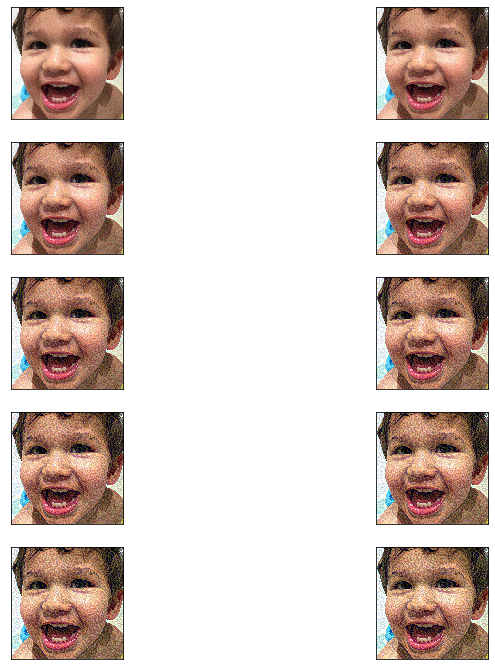

In [67]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

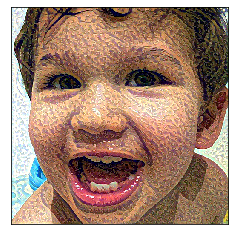

In [68]:
display_image(final)